In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

import timeit
import wandb
import random

import re

from tqdm import tqdm
tqdm.pandas()

### Settings stuff

In [2]:
random.seed(10)

training_mode = True
act_func = "tanh"

epochs = 400
batch_size = 128

learning_rate = 1e-5
hidden_size = 32


comp_used = 500 #Same as input_size
word_lim = 10

drop_prob = 0.5


rand_guessing = False
lower_text = True
mx_norm = 15
input_size = comp_used

loss_fn = nn.BCELoss()

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")



### Importing the training set and saving it as train_df

In [3]:
def remove_repeat_recursively(text, target_chars, rep_token, add_space = False):
    end = len(text)-1
    for i,c in enumerate(text):
        cnt = 1
        if c == target_chars:
            end = i #The new end point is at i for the string to be returned

            try: #Tries to figure out where the last target_chars in the run is.
                while text[i + cnt] == target_chars:
                    cnt += 1
            except: #If it returns an exception then all remaining chars are the target and we're done.
                if add_space:
                    if cnt > 1:
                        return text[0:end] + " " + target_chars + " " + rep_token
                    else:
                        return text[0:end] + " " + target_chars
                else:
                    if cnt > 1:
                        return text[0:end+1] + " " + rep_token
                    else:
                        return text[0:end+1]

            if cnt == 1:
                if add_space:
                    return text[0:end] + " " + target_chars + " " + remove_repeat_recursively(text[end + cnt:len(text)], target_chars, rep_token, add_space)
                else:
                    return text[0:end + 1] + remove_repeat_recursively(text[end + cnt:len(text)], target_chars, rep_token)

            if add_space:
                return text[0:end] + " " + target_chars + " " + rep_token + " " + remove_repeat_recursively(text[end + cnt:len(text)], target_chars, rep_token, add_space)
            else:
                return text[0:end + 1] + " " + rep_token + " " + remove_repeat_recursively(text[end + cnt:len(text)], target_chars, rep_token)
    return text



In [4]:
#Helper functions to clean up sentences

def help_cleaner(text):

    text_og = text
    if lower_text:
        text = text.lower()

    pat = re.compile("[^a-zA-Z!?:;,.'@#0-9#\[\]\-/]")
    text = re.sub(pat, ' ', text)

    #People have a tendancy to use multiple exclamation or question marks which may throw off the vectorizer later.
    #To solve this we'll turn "!!!!" into "! MultipleExclToken" where the token helps retain meaning
    text = remove_repeat_recursively(text, "!", "MultipleExclTokenRandomjunkidentifier", True)
    text = remove_repeat_recursively(text, "?", "MultipleQuestTokenRandomjunkidentifier", True)
    text = remove_repeat_recursively(text, ".", "MultiplePerTokenRandomjunkidentifier", False)
    text = remove_repeat_recursively(text, "-", "MultipleHyphTokenRandomjunkidentifier", False)
    text = remove_repeat_recursively(text, ":", "MultipleColonTokenRandomjunkidentifier", False)
    text = remove_repeat_recursively(text, ";", "MultipleSemicolonTokenRandomjunkidentifier", True)
    text = text.replace("#", " hashtag ")
    text = text.split()



    for i,x in enumerate(text):
        if x[len(x)-1] == "." and len(x) > 1:
            x = x[0:len(x)-1] + " " + "."
        try:
            y = x.replace(",", "")

            if int(y) > 10000:
                text[i] = "BigNumberRandomjunkidentifier"
            elif int(y) > 25:
                text[i] = "MediumishNumberRandomjunkidentifier"
            else:
                text[i] = "SmallishNumberRandomjunkidentifier"
        except: #If an error is thrown then it's because x cannot be converted to an integer (ignoring commas) so treat it as just a string

            #Brute force stemming the s off of things. If it's singular then it doesn't change much ie. 'this' -> 'thi' but it does it everywhere
            #so no big change as far as the network will be concerned.

            if x[len(x)-1] == "s" and len(x) > 1:
                y = x[0:len(x)-1]
            else:
                y = x

            #If it's a URL then just truncate it to https or http
            if x[0:5] == "https":
                y = "https"
            elif x[0:4] == "http":
                y = "http"

            #Some symbols are useful for understanding a tweet such as the hashtag, at symbol, and quotes.
            if y[0] == "#" or y[0] == "@" or y[0] == "\'" or y[0] == "\"":
                y = y[0] + " " + y[1:len(y)] #If it's any of these 'left sided' signifiers then we add a space between it and the next char

            if y[len(y)-1] == "\"" or y[len(y)-1] == "\'": #If it's the right side then it adds a space between it and the char before it
                y = y[0:len(x)-1] + " " + y[len(y)-1]

            text[i] = y


    return " ".join(text)

In [6]:
train_df = pd.read_csv('train.csv', index_col= 0)
train_df.drop(["keyword", "location"], axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords
pd.set_option('display.max_colwidth', None)

train_df['text'] = train_df['text'].apply(help_cleaner)

train_df

,text,target
id,,
1,our deed are the reason of thi hashtag earthquake may allah forgive u all,1
4,forest fire near la ronge sask . canada,1
5,all resident asked to ' shelter in place ' are being notified by officers . no other evacuation or shelter in place order are expected,1
6,BigNumberRandomjunkidentifier people receive hashtag wildfire evacuation order in california,1
7,just got sent thi photo from ruby hashtag alaska a smoke from hashtag wildfire pour into a school,1
...,...,...
10869,two giant crane holding a bridge collapse into nearby home http,1
10870,@ aria ahrary @ thetawniest the out of control wild fire in california even in the northern part of the state . very troubling .,1
10871,m1.94 [01:04 utc] ? 5km s of volcano hawaii . http,1


### Importing test set just like the training set

In [7]:
test_df = pd.read_csv('test.csv', index_col= 0)
test_df.drop(["keyword","location"], axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords

test_df['text'] = test_df['text'].apply(help_cleaner)

test_df

,text
id,
0,just happened a terrible car crash
2,"heard about hashtag earthquake i different cities, stay safe everyone ."
3,"there i a forest fire at spot pond, geese are fleeing acros the street, i cannot save them all"
9,apocalypse lighting . hashtag spokane hashtag wildfire
11,typhoon soudelor kill MediumishNumberRandomjunkidentifier in china and taiwan
...,...
10861,earthquake safety lo angele safety fastener xrwn
10865,storm in ri worse than last hurricane . my city amp ; 3other hardest hit . my yard look like it wa bombed . around 20000k still without power
10868,green line derailment in chicago http


In [8]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

In [9]:
#tokenizer_used = feature_extraction.text.CountVectorizer(min_df = 2)
tokenizer_used = feature_extraction.text.TfidfVectorizer(min_df = 2)

mat = tokenizer_used.fit_transform(train_df["text"])

vocab = tokenizer_used.vocabulary_

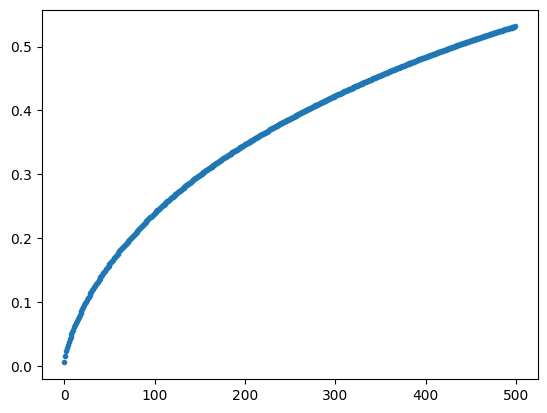

In [10]:


#0.86 is explained by only 2000 components out of over 6000!
#0.794 is explained by 1500 components. A little more than from my original notebook where I did no pre-processing to text (0.78)
#0.70 is explained by only 1000 components!
#0.53 is explained by only 500 components!
#0.38 is explained by only 250 components
#0.26 is explained by only 125 components
#0.15 is explained by only 50 components
#0.09 is explained by only 25 components


svd = TruncatedSVD(n_components = comp_used, random_state = 1) #Initializing the SVD settings. We intend to keep comp_used components

svd.fit(mat)


c = Cumulative(svd.explained_variance_)
plt.plot(range(len(svd.explained_variance_)), c, '.') #A plot of variance explained vs number of components used

In [11]:
len(vocab)
#Before processing it was almost 6600 words/tokens and now it's down to 6104.

6103

In [12]:
test_mat = tokenizer_used.transform(test_df['text'])

In [13]:
col_names = [list(vocab.keys())[list(vocab.values()).index(i)] for i in range(len(vocab))]

vectorizer_mat = pd.DataFrame(mat.toarray(), columns = col_names)#.apply(sum)
vectorizer_mat.index = train_df.index

test_mat = tokenizer_used.transform(test_df['text'])
vectorizer_test_mat = pd.DataFrame(test_mat.toarray(), columns = col_names)
vectorizer_test_mat.index = test_df.index


In [14]:
v_tran = pd.DataFrame(svd.components_, columns = col_names)
v_tran

,00,000,01,02,03,030,04,05,06,07,...,zero,zimbabwe,zionism,zionist,zippednew,zipper,zombie,zone,zouma,zs
0,0.005230,0.000656,0.003842,0.000848,0.000572,0.000148,0.002107,0.002790,0.003295,0.002898,...,0.000428,0.000411,0.001369,0.002234,0.001605,0.000243,0.002678,0.007173,0.000953,0.000209
1,0.004864,-0.000968,0.005565,0.000678,-0.000131,-0.000060,0.002707,0.002168,0.004426,0.002255,...,-0.000547,-0.000551,0.002253,0.002739,0.002017,0.000060,-0.000689,-0.004537,-0.000719,-0.000052
2,0.005354,-0.000586,0.002623,0.001005,0.002148,0.000420,0.001841,0.003899,0.003084,0.002625,...,0.000373,0.000256,-0.001275,-0.000464,0.002211,0.001084,-0.000022,-0.003241,-0.003292,0.001030
3,-0.003023,0.000671,0.000345,-0.001307,-0.001382,-0.000578,0.001225,-0.001014,-0.001567,-0.001510,...,-0.000494,0.001042,0.001273,-0.002327,-0.000555,-0.001452,-0.000003,0.006369,-0.002111,-0.000746
4,0.002322,0.000820,0.001370,0.000365,0.000107,0.000277,0.000130,0.000785,0.000499,0.000453,...,-0.000018,-0.000184,0.000022,-0.001893,-0.001666,-0.000017,0.000578,0.004494,0.008823,0.000232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.032766,0.002885,-0.008219,0.002817,0.001527,0.004000,-0.007223,0.017255,-0.000407,-0.009959,...,-0.000643,0.000456,0.002248,-0.001503,0.001300,0.002375,-0.000879,-0.021293,-0.001144,0.001113
496,0.012287,0.006714,0.017821,-0.004835,0.002070,-0.005958,0.010866,-0.026718,0.012169,-0.002134,...,0.005540,0.000287,0.006003,0.015403,-0.000095,-0.000812,0.006290,-0.007303,-0.002284,0.000812
497,0.000328,0.001516,-0.029046,-0.004982,-0.004381,0.007970,-0.010910,0.021521,-0.016915,-0.004392,...,-0.002763,0.000262,-0.000830,-0.005007,0.000717,0.001490,0.008307,-0.034604,-0.014846,-0.002714
498,-0.021834,-0.002022,0.000158,0.001394,0.007356,0.000340,-0.002224,-0.001971,0.008505,0.016830,...,-0.001664,0.009537,0.007083,0.012974,-0.000612,0.001583,-0.006504,-0.059354,-0.004986,0.007947


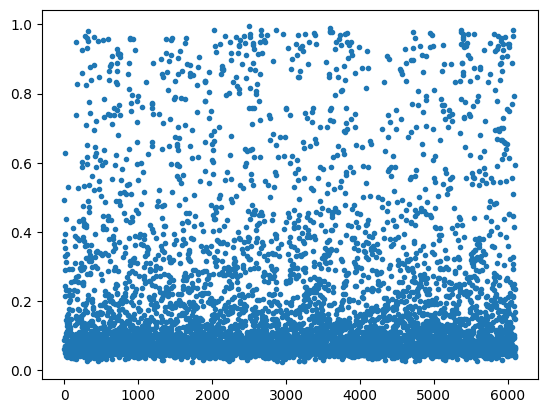

In [15]:
list_norms = []
for i in range(6103):
    list_norms.append(np.linalg.norm(svd.components_[:,i]))
plt.plot(list_norms, '.')

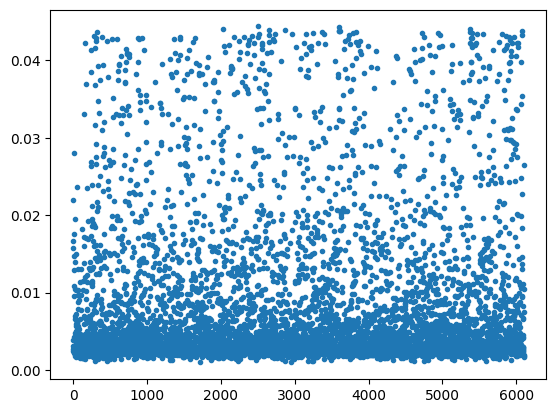

In [16]:
list_std = []
for i in range(6103):
    list_std.append(np.std(svd.components_[:,i]))
plt.plot(list_std, '.')

In [17]:
v_tran["fire"].sort_values

<bound method Series.sort_values of 0      0.058128
1     -0.023484
2      0.044895
3     -0.030231
4      0.008923
         ...   
495   -0.005543
496    0.021205
497    0.003456
498    0.005382
499    0.010080
Name: fire, Length: 500, dtype: float64>

In [18]:
v_tran.loc[14].sort_values(ascending = False).head(25)

on                                        0.320217
fire                                      0.277866
to                                        0.272736
in                                        0.219220
from                                      0.116793
that                                      0.095831
building                                  0.084639
we                                        0.081221
mh370                                     0.076622
the                                       0.076098
crash                                     0.074529
are                                       0.073546
debri                                     0.067868
there                                     0.067057
be                                        0.066144
multiplequesttokenrandomjunkidentifier    0.065453
multiplepertokenrandomjunkidentifier      0.063690
forest                                    0.062403
reunion                                   0.052952
malaysia                       

In [19]:
v_tran.loc[15].sort_values(ascending = False).head(25)

on                                     0.342461
my                                     0.257692
fire                                   0.204086
than                                   0.186896
have                                   0.186000
been                                   0.166857
https                                  0.161888
oil                                    0.141637
spill                                  0.138688
mediumishnumberrandomjunkidentifier    0.138161
of                                     0.133359
projected                              0.123434
may                                    0.122416
bigger                                 0.122134
costlier                               0.121600
refugio                                0.121600
legionnaires                           0.090485
are                                    0.072108
fatal                                  0.060544
in                                     0.058190
over                                   0

In [20]:
v_tran.loc[22].sort_values(ascending = False).head(25)

are                                     0.303238
we                                      0.285826
and                                     0.197857
up                                      0.193910
video                                   0.192235
migrant                                 0.138536
multiplepertokenrandomjunkidentifier    0.133728
hundred                                 0.132869
re                                      0.132869
rescuer                                 0.128137
searching                               0.122516
fire                                    0.121069
bodie                                   0.120175
picking                                 0.117097
suicide                                 0.110291
they                                    0.103158
bomb                                    0.102431
water                                   0.102117
bomber                                  0.096202
like                                    0.095883
old                 

In [21]:
(v_tran["car"] - v_tran["cat"]).apply(abs).values.sum()

15.059433756832718

In [22]:
(v_tran["dog"] - v_tran["cat"]).apply(abs).values.sum()

12.922319050257173

In [23]:
(v_tran["kitten"] - v_tran["cat"]).apply(abs).values.sum()

5.441718927390243

In [24]:
(v_tran["cold"] - v_tran["hot"]).apply(abs).values.sum()

10.440753717922712

We expect that the difference between a car and cat should be relatively large even though they're "close" in terms of characters.
Similarly, we expect cold and hot to be far apart. We expect dog and cat to be far apart compared to kitten and cat but also closer than car.

We see this which is a good sign!

In [25]:
sum_of_tfidf = vectorizer_mat.apply(sum)

In [26]:
sum_of_tfidf.sort_values(ascending=False).head(25)

http                                      370.609488
hashtag                                   360.645483
the                                       320.532338
in                                        222.787716
to                                        218.651203
of                                        205.375249
and                                       176.640725
multiplepertokenrandomjunkidentifier      147.645049
you                                       144.632811
it                                        131.016224
for                                       129.402515
on                                        127.363657
multiplequesttokenrandomjunkidentifier    125.009993
smallishnumberrandomjunkidentifier        119.648185
my                                        115.729855
that                                      101.743982
mediumishnumberrandomjunkidentifier        97.083009
with                                       92.035371
by                                         91.

### Attempting with a custom RNN

Started off following this tutorial by Diego Velez.

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

In [27]:
class RNN(nn.Module): #We call nn.Module because we want RNN to inherit from Module.
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size


        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)


        self.i2h_back = nn.Linear(input_size, hidden_size)
        self.h2h_back = nn.Linear(hidden_size, hidden_size)

        self.h2h_comb = nn.Linear(hidden_size, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh() #nn.ReLU()

        self.input_LNorm_f = nn.LayerNorm(input_size)
        self.input_LNorm_b = nn.LayerNorm(input_size)

        self.drop_layer = nn.Dropout(p=drop_prob)

    def forward(self, x_forward, x_back, hidden_state_forward = None, hidden_state_back = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns computed output and tanh(i2h + h2h)
        Inputs
        ------
        x: Input vector
        hidden_state: Previous hidden state
        Outputs
        -------
        out: Linear output (without activation because of how pytorch works)
        hidden_state: New hidden state matrix
        """

        if hidden_state_back is None:
            hidden_state_forward = self.init_zero_hidden()
            hidden_state_back = self.init_zero_hidden()

        x_forward = self.input_LNorm_f(x_forward)
        x_back = self.input_LNorm_b(x_back)

        x_forward = self.i2h(x_forward)
        x_back = self.i2h_back(x_back)

        x_forward = self.drop_layer(x_forward)
        x_back = self.drop_layer(x_back)

        hidden_state_forward = self.h2h(hidden_state_forward)
        hidden_state_back = self.h2h_back(hidden_state_back)

        hidden_state_forward = self.drop_layer(hidden_state_forward)
        hidden_state_back = self.drop_layer(hidden_state_back)

        hidden_state_forward = self.act(x_forward + hidden_state_forward)
        hidden_state_back = self.act(x_back + hidden_state_back)

        hidden_state = self.h2h_comb(hidden_state_forward + hidden_state_back)

        out = self.h2o(hidden_state)

        return out, hidden_state_forward, hidden_state_back


    def init_zero_hidden(self) -> torch.Tensor:
        """
        Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(self.hidden_size, requires_grad=False, dtype = torch.double).to(device)

In [80]:
train_losses = {}
val_losses = {}
val_batch_losses = []

t1_val = []
t2_val = []

layer_one_weights = []
layer_last_weights = []

layer_last_grads = []

def train(model: RNN, data: DataLoader, val_data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    Inputs
    ------
    model: RNN model to train
    data: Iterable DataLoader
    epochs: Number of epochs to train the model
    optiimizer: Optimizer to use for each epoch
    loss_fn: Function to calculate loss
    """
    model.to(device)


    print("=> Starting training")

    for epoch in range(epochs):
        model.train()
        epoch_losses = list()
        for X, Y in data:
            # send tensors to device
            X,Y = X.double(), Y.double()
            X, Y = X.to(device), Y.to(device)
            # 2. clear gradients
            optimizer.zero_grad()

            if not rand_guessing:
                hidden_forward = None
                hidden_back = None

                for i in range(word_lim):
                    if hidden_back is not None:
                        out, hidden_forward, hidden_back = model(X[:,i].to(device), X[:,word_lim-i-1].to(device), hidden_forward[:].to(device), hidden_back[:].to(device))
                    else:
                        out, hidden_forward, hidden_back = model(X[:,i].to(device), X[:,word_lim-i-1].to(device))

                t1 = torch.sigmoid(out).squeeze() #Maybe try with tanh instead of sigmoid.

                layer_one_weights.append(model.i2h.weight.clone())
                layer_last_weights.append(model.h2o.weight.clone())



                loss = loss_fn(t1, Y)

                # 4. Compte gradients
                loss.backward()
                layer_one_grads.append(model.i2h.weight.grad)
                layer_last_grads.append(model.h2o.weight.grad)

                # 5. Adjust learnable parameters
                # clip as well to avoid vanishing and exploding gradients

                nn.utils.clip_grad_norm_(model.parameters(), mx_norm)
                optimizer.step()
            else:
                t1 = torch
                loss = loss_fn(t1,Y)

            epoch_losses.append(loss.detach().item())

        train_losses[epoch] = torch.tensor(epoch_losses).mean()

        if (epoch+1)%10==0:
            print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')

        if val_data is not None:
            model.eval()
            val_epoch_losses = list()
            with torch.no_grad():
                for val_x, val_y in val_data:
                    loss = 0

                    val_x, val_y = val_x.double(), val_y.double()
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)

                    hidden_forward = None
                    hidden_back = None

                    for i in range(word_lim):
                        if hidden_back is not None:
                            out, hidden_forward, hidden_back = model(val_x[:,i].to(device), val_x[:,word_lim-i-1].to(device), hidden_forward[:].to(device), hidden_back[:].to(device))
                        else:
                            out, hidden_forward, hidden_back = model(val_x[:,i].to(device), val_x[:,word_lim-i-1].to(device))

                    t1 = np.rint(torch.sigmoid(out).squeeze().cpu().detach().numpy()).astype(int)
                    t2 = np.rint(val_y.cpu().detach().numpy()).astype(int)

                    loss = metrics.f1_score(t2,t1)

                    val_epoch_losses.append(loss)
                    val_batch_losses.append(loss)
                    t1_val.append(t1)
                    t2_val.append(t2)


                val_losses[epoch] = sum(val_epoch_losses)/len(val_epoch_losses)


def predict(model: RNN, data: DataLoader) -> None:
    model.to(device)
    model.eval()

    with torch.no_grad():
        for test_x in data:
            test_x = test_x.double().to(device)
            hidden_forward = None
            hidden_back = None

            for i in range(word_lim):
              if hidden_back is not None:
                out, hidden_forward, hidden_back = model(test_x[:,i], test_x[:,word_lim-1-i], hidden_forward[:].to(device), hidden_back[:].to(device))
              else:
                out, hidden_forward, hidden_back = model(test_x[:,i], test_x[:,word_lim-1-i])

            return np.rint(torch.sigmoid(out).squeeze().cpu().detach().numpy()).astype(int)


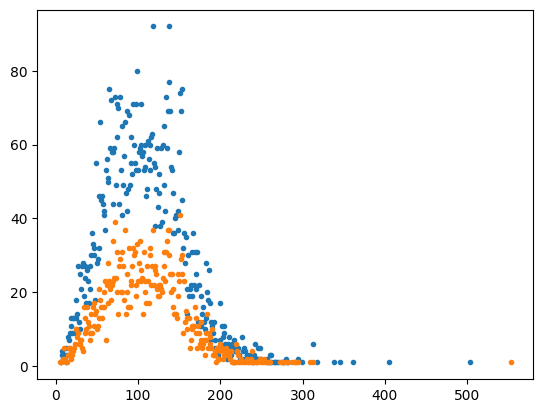

In [29]:
temp = train_df['text'].apply(len)
temp2 = temp.groupby(temp).count()
plt.plot(temp2, '.')

temp = test_df['text'].apply(len)
temp2 = temp.groupby(temp).count()
plt.plot(temp2, '.')

The character count is really messed up because of my long custom tokens I added to avoid accidentally messing with the data.
But I'll be using word vectorization anyway so the length of the tokens doesn't matter.

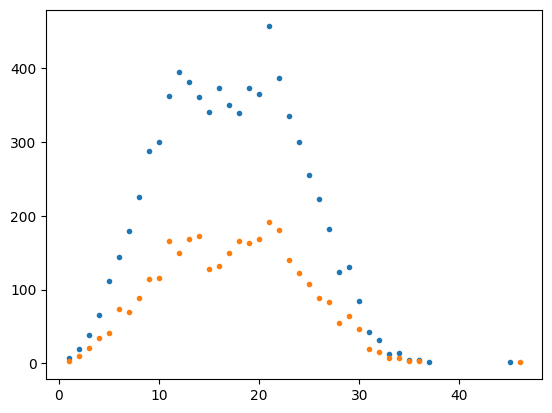

In [30]:
temp = train_df['text'].apply(str.split).apply(len)
temp2 = temp.groupby(temp).count()
plt.plot(temp2, '.')

temp = test_df['text'].apply(str.split).apply(len)
temp2 = temp.groupby(temp).count()
plt.plot(temp2, '.')

Ignore this. It's old -> The maximum character count across the datasets is less than 160 and word count rarely exceeds 30 so we'll use 35 words as a cut off.

New -> We have a few sentences now that are longer than 40 'words' but that's largely due to the tokenization applied.
When it comes to training I'll probably just use a function to condense sentences by dropping useless info.
If I use TF-IDF then it should come naturally.

### Training using the RNN

In [79]:
class CustomTweetDataset(Dataset):
    def __init__(self, x_data, y_data = None):
        self.data = x_data
        if y_data is not None:
            y_data = torch.tensor(y_data.values)
        self.y_data = y_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.y_data is not None:
          return (self.data[idx], self.y_data[idx])
        else:
          return(self.data[idx])

In [32]:
train_df_complete = train_df.copy(deep=True)

In [33]:
train_df = train_df_complete.sample(frac = 0.8)
val_df = train_df_complete.drop(train_df.index)

In [34]:
#7612 rows * 30 words (at max) * comp_used (50 or less) = a tensor with 11,418,000 elements

def help_func(data, test_data = False):
    text_tensor = torch.zeros((len(data),word_lim,comp_used), dtype = torch.float)

    for i,idx in enumerate(data.index):
        text = data.loc[idx]['text'].split()

        text = help_func3(text, idx, test_data)

        for word_loc_in_text, x in enumerate(map(help_func2, text)):
            text_tensor[i, word_loc_in_text] = x

    text_tensor.requires_gradient = True
    return text_tensor

#Takes a word that's in vocab and returns its column representation in V transpose.
#If it's not in the vocab then it just returns a zero tensor.
def help_func2(x):
    if x in v_tran.columns:
        return torch.tensor(v_tran[x])
    else:
        return torch.zeros(comp_used, dtype = torch.float) #If it's not in the vocab then it returns a -2 and -1 is used for padding.


def help_func3(text: list, idx, test_data):
    #We are reducing the list to be equal to word_lim

    if test_data:
        text_weight_list = vectorizer_test_mat.loc[idx].apply(abs).sort_values(ascending = False).head(word_lim)[vectorizer_test_mat.loc[idx].apply(abs).sort_values(ascending = False).head(word_lim) > 1e-6]
    else:
        text_weight_list = vectorizer_mat.loc[idx].apply(abs).sort_values(ascending = False).head(word_lim)[vectorizer_mat.loc[idx].apply(abs).sort_values(ascending = False).head(word_lim) > 1e-6]

    text_weight_list = list(text_weight_list.index)

    if len(text_weight_list) > word_lim:
        text_weight_list = text_weight_list[0:word_lim]

    temp_text = []

    for x in text:
        if x in text_weight_list:
            if len(temp_text) < word_lim:
                temp_text.append(text_weight_list.index(x))
            else:
                temp_text.remove(min(temp_text))
                temp_text.append(text_weight_list.index(x))

    return [text_weight_list[weight_idx] for weight_idx in temp_text]


start = timeit.default_timer()

train_x = help_func(train_df)
val_x = help_func(val_df)

stop = timeit.default_timer()
print(stop-start)

162.697143397


In [35]:
train_dataset = CustomTweetDataset(train_x, train_df['target'])
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)

val_dataset = CustomTweetDataset(val_x, val_df['target'])
val_dataloader = DataLoader(val_dataset, batch_size, shuffle = True)

#test_dataset = CustomTweetDataset(test_x)
#test_dataloader = DataLoader(test_dataset, batch_size, shuffle = True)



In [36]:
model = RNN(input_size, hidden_size, 1)
model.to(device)
model.double()
loss_fn.to(device)

my_optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

train_losses = {}
val_losses = {}
val_batch_losses = []

t1_val = []
t2_val = []

layer_one_weights = []
layer_one_grads = []

layer_last_weights = []
layer_last_grads = []

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

37265

In [38]:
start = timeit.default_timer()
train(model, train_dataloader, val_dataloader, epochs, my_optimizer, loss_fn)
stop = timeit.default_timer()
print(stop-start)

=> Starting training
=> epoch: 10, loss: 0.6981175541877747
=> epoch: 20, loss: 0.6844142079353333
=> epoch: 30, loss: 0.6744639873504639
=> epoch: 40, loss: 0.6641256213188171
=> epoch: 50, loss: 0.6507528424263
=> epoch: 60, loss: 0.6399032473564148
=> epoch: 70, loss: 0.6244361996650696
=> epoch: 80, loss: 0.6060839295387268
=> epoch: 90, loss: 0.5907474160194397
=> epoch: 100, loss: 0.5675814747810364
=> epoch: 110, loss: 0.5458317399024963
=> epoch: 120, loss: 0.5209167003631592
=> epoch: 130, loss: 0.5046335458755493
=> epoch: 140, loss: 0.48566409945487976
=> epoch: 150, loss: 0.46738681197166443
=> epoch: 160, loss: 0.45513513684272766
=> epoch: 170, loss: 0.4508400857448578
=> epoch: 180, loss: 0.4325364828109741
=> epoch: 190, loss: 0.42990484833717346
=> epoch: 200, loss: 0.4256421625614166
=> epoch: 210, loss: 0.41658198833465576
=> epoch: 220, loss: 0.4165534973144531
=> epoch: 230, loss: 0.4081287384033203
=> epoch: 240, loss: 0.40256866812705994
=> epoch: 250, loss: 0.40

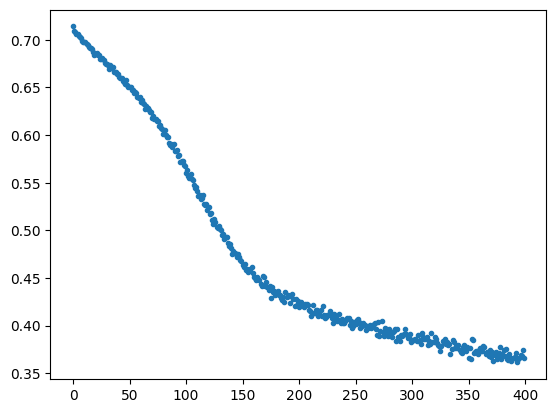

In [63]:
plt.plot(list(map(torch.Tensor.item,train_losses.values())), '.')

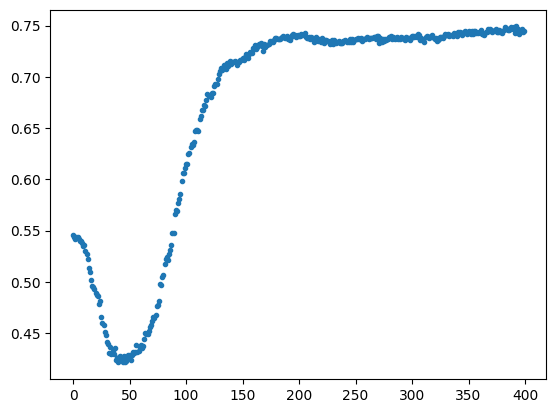

In [64]:
plt.plot(list(val_losses.values()), '.')
ax = plt.gca()
#ax.set_ylim([0.58, 0.63])

In [65]:
metrics.confusion_matrix(t2_val[0], t1_val[0]) #00 TN, 10 FN, 11 TP, 01 FP

# [TN, FP,
# FN, TP]

array([[13, 64],
       [10, 41]])

In [66]:
metrics.confusion_matrix(t2_val[len(t2_val)-1], t1_val[len(t1_val)-1])

array([[57,  6],
       [ 8, 44]])

In [43]:
t1_val[0]

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
t1_val[len(t1_val)-1]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0])

In [45]:
t2_val[len(t1_val)-1]

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0])

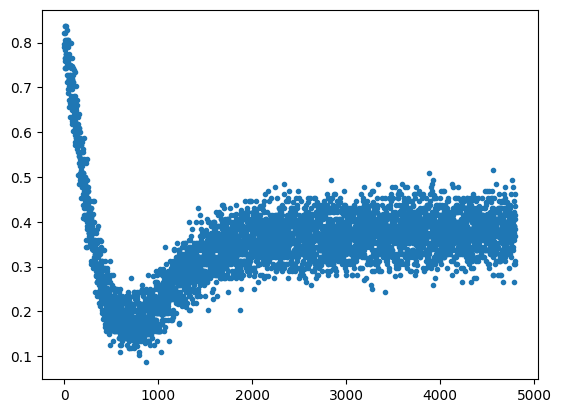

In [46]:
plt.plot([sum(x)/len(x) for x in t1_val], '.') #Plotting what portion of predictions were 1's every validation batch

In [47]:
len(val_losses.values())

400

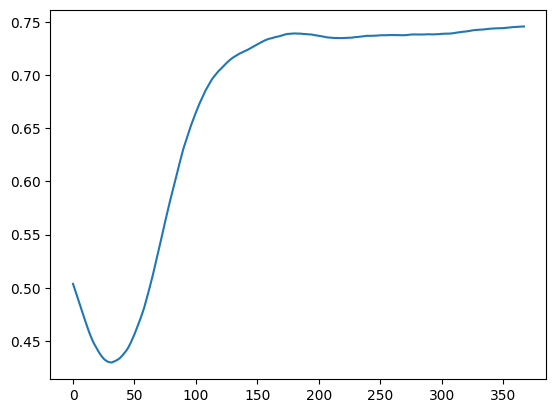

In [48]:
l2 = []
for i in range(len(val_losses.values())-32):
    l2.append(sum(list(val_losses.values())[i:i+32])/32)
plt.plot(l2)

In [49]:
print(max(list(val_losses.values())))

0.7490860906766593


In [50]:
l2 = []
for i in range(len(val_batch_losses)-32):
    l2.append(sum(val_batch_losses[i:i+32])/32)

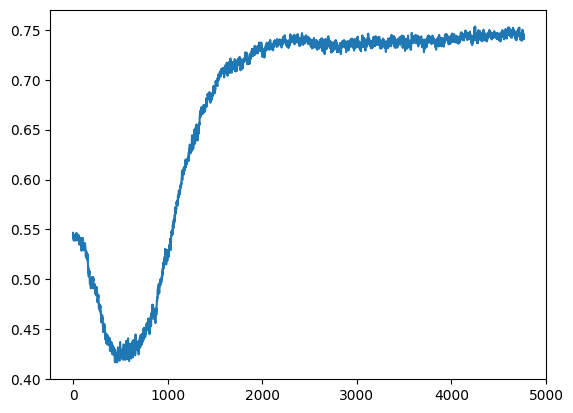

In [51]:
plt.plot(l2) #Moving mean of the val_batch_losses. i.e. movin mean of F1 score across batches

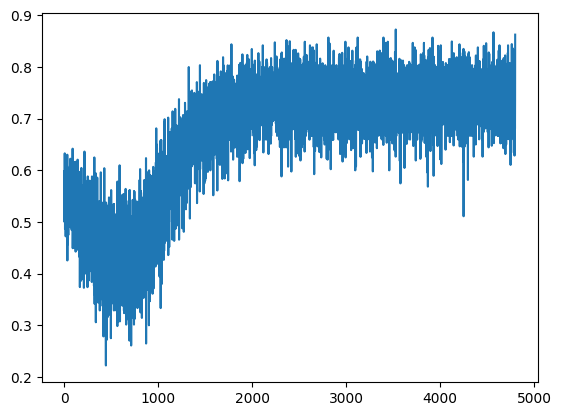

In [52]:
plt.plot(val_batch_losses) #Same as above but no moving mean

In [53]:
print(layer_last_grads[0])
print(layer_last_grads[len(layer_last_grads)-1])
print(torch.norm(layer_last_grads[0]))
print(torch.norm(layer_last_grads[len(layer_last_grads)-1]))


tensor([[-0.0342, -0.0003,  0.0246,  0.0136, -0.0295,  0.0071, -0.0141, -0.0038,
         -0.0340, -0.0251,  0.0454,  0.0201, -0.0364,  0.0047, -0.0428, -0.0233,
         -0.0076, -0.0129, -0.0212,  0.0053, -0.0099,  0.0314, -0.0112, -0.0117,
          0.0061,  0.0212,  0.0058,  0.0227,  0.0111, -0.0091,  0.0104,  0.0154]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.0082,  0.0076, -0.0237, -0.0115,  0.0110, -0.0139,  0.0026,  0.0161,
         -0.0016, -0.0120,  0.0299, -0.0095, -0.0068, -0.0112,  0.0030, -0.0113,
         -0.0038,  0.0006, -0.0026, -0.0152, -0.0167, -0.0153,  0.0202, -0.0036,
          0.0024,  0.0202,  0.0063, -0.0019, -0.0107, -0.0065, -0.0059,  0.0165]],
       device='cuda:0', dtype=torch.float64)
tensor(0.1212, device='cuda:0', dtype=torch.float64)
tensor(0.0703, device='cuda:0', dtype=torch.float64)


In [54]:

print(layer_one_grads[0])
print(layer_one_grads[len(layer_one_grads)-1])
print(torch.norm(layer_one_grads[0]))
print(torch.norm(layer_one_grads[len(layer_one_grads)-1]))

tensor([[ 2.9695e-02,  3.3926e-02, -4.2294e-03,  ...,  2.1164e-03,
          3.8160e-03,  1.7577e-03],
        [-1.3049e-02, -8.2445e-03, -1.9250e-02,  ...,  3.5527e-03,
          5.0604e-03, -6.4044e-03],
        [ 6.1884e-03,  2.8684e-03, -9.8934e-04,  ..., -1.4944e-03,
         -2.4991e-03,  8.6990e-04],
        ...,
        [-1.4333e-02, -2.5183e-02,  1.8934e-02,  ..., -1.3550e-03,
          1.2321e-03, -7.0257e-04],
        [-9.3206e-03, -4.9793e-03,  1.2849e-02,  ..., -2.7204e-03,
         -2.1446e-03, -1.9055e-03],
        [ 7.8362e-03,  1.0703e-02, -7.1660e-03,  ..., -1.0042e-03,
         -2.3603e-05,  4.7457e-04]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.0190, -0.0142,  0.0560,  ...,  0.0011, -0.0014,  0.0057],
        [-0.0405,  0.0221, -0.0328,  ..., -0.0232,  0.0289, -0.0024],
        [-0.0489, -0.1632,  0.0963,  ...,  0.0140,  0.0099,  0.0148],
        ...,
        [-0.0353, -0.0768,  0.0207,  ..., -0.0016,  0.0065,  0.0077],
        [ 0.0757,  0.0977, -0.0383,  

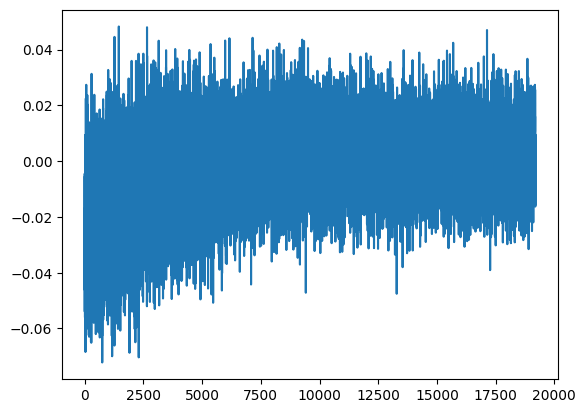

In [55]:
#seeing how the grads change over time of the last layer.
l = []
for x in layer_last_grads: #As it goes through each x, it's passing through each iteration from oldest to newest
    l.append(x[0][0].item()) #First number isn't important because the last layer is only one linear layer.
                            #Second number is which specific gradient we are looking at in that specific layer

plt.plot(l)

In [56]:
print(sum(p.numel() for p in model.parameters()))

37265


In [57]:
layer_last_weights[0]

tensor([[-0.1102,  0.1240,  0.0327, -0.1354, -0.1038, -0.0623,  0.0221, -0.0767,
         -0.1380, -0.0372,  0.0342, -0.0227, -0.1492,  0.0184, -0.1528, -0.1666,
          0.1455,  0.0478,  0.0750, -0.1408, -0.0880, -0.0557, -0.1740,  0.0022,
          0.0428,  0.0684, -0.0253,  0.1595,  0.0449, -0.0709,  0.0428,  0.0003]],
       device='cuda:0', dtype=torch.float64, grad_fn=<CloneBackward0>)

In [58]:
layer_last_weights[len(layer_last_weights)-1]

tensor([[-0.1004,  0.1227,  0.0646, -0.1965, -0.1454, -0.1430,  0.0125, -0.1080,
         -0.1995, -0.0990,  0.0405,  0.0273, -0.2067, -0.0330, -0.2031, -0.2403,
          0.2193,  0.0523,  0.1461, -0.2105, -0.1109, -0.0872, -0.2374,  0.0409,
          0.0708,  0.1410, -0.0579,  0.2322, -0.0008, -0.1310,  0.0600, -0.0439]],
       device='cuda:0', dtype=torch.float64, grad_fn=<CloneBackward0>)

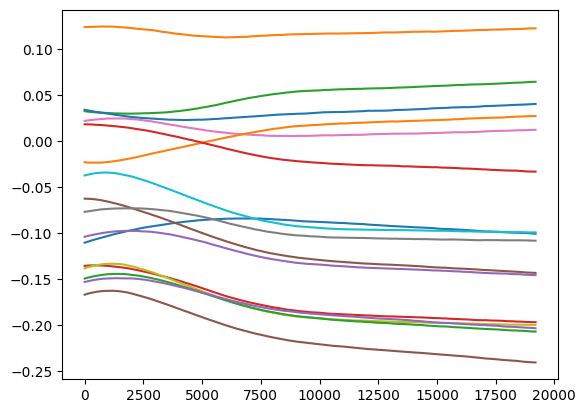

In [59]:
for i in range(int(hidden_size/2)):
    l = []
    for x in layer_last_weights:
        l.append(x[0][i].item())
    plt.plot(l)

In [60]:
len(layer_one_weights)

19200

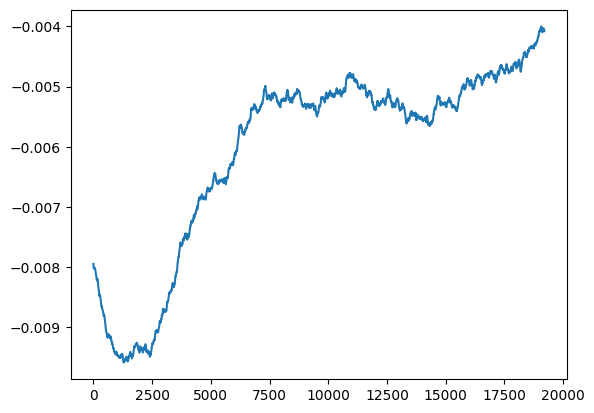

In [61]:
l = []
for x in layer_one_weights:
    l.append(x[0][0].item()) #1st number is which of the linear layers that make up the first layer to look at
    #2nd number is which gradient in that layer

plt.plot(l)

In [71]:
training_mode = False
if not training_mode:

    train_x_complete = help_func(train_df_complete)

    train_dataset = CustomTweetDataset(train_x_complete, train_df_complete['target'])
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)


    model = RNN(input_size, hidden_size, 1)
    model.to(device)
    model.double()
    loss_fn.to(device)

    my_optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

In [75]:
if not training_mode:
    #epochs = 163

    start = timeit.default_timer()
    train(model, train_dataloader, val_dataloader, epochs, my_optimizer, loss_fn)
    stop = timeit.default_timer()

=> Starting training
=> epoch: 10, loss: 0.6924208402633667
=> epoch: 20, loss: 0.6803462505340576
=> epoch: 30, loss: 0.6695088148117065
=> epoch: 40, loss: 0.656940758228302
=> epoch: 50, loss: 0.6456356048583984
=> epoch: 60, loss: 0.6292693614959717
=> epoch: 70, loss: 0.6128372550010681
=> epoch: 80, loss: 0.593908965587616
=> epoch: 90, loss: 0.572756826877594
=> epoch: 100, loss: 0.5473989248275757
=> epoch: 110, loss: 0.5267689824104309
=> epoch: 120, loss: 0.4996826946735382
=> epoch: 130, loss: 0.4851694703102112
=> epoch: 140, loss: 0.47296178340911865
=> epoch: 150, loss: 0.4557105600833893
=> epoch: 160, loss: 0.44965988397598267
=> epoch: 170, loss: 0.44037926197052
=> epoch: 180, loss: 0.4294368624687195
=> epoch: 190, loss: 0.4240491986274719
=> epoch: 200, loss: 0.42432084679603577
=> epoch: 210, loss: 0.4175254702568054
=> epoch: 220, loss: 0.4187202453613281
=> epoch: 230, loss: 0.4181884229183197
=> epoch: 240, loss: 0.4072827696800232
=> epoch: 250, loss: 0.4100224

In [81]:
if not training_mode:
    test_x = help_func(test_df, True)
    test_dataset = CustomTweetDataset(test_x)
    test_dataloader = DataLoader(test_dataset, len(test_x), shuffle = False)

    start = timeit.default_timer()
    predictions = predict(model, test_dataloader)
    stop = timeit.default_timer()

    print(stop-start)

0.5496249460002218


In [82]:
if not training_mode:
    pd.DataFrame(predictions, columns = ["target"]).set_index(test_df.index).to_csv("submission_complex_NN.csv")

In [128]:
use_torchRNN = True

train_dataset = CustomTweetDataset(train_x, train_df['target'])
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)

def train_torch(model: RNN, data: DataLoader, val_data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    Inputs
    ------
    model: RNN model to train
    data: Iterable DataLoader
    epochs: Number of epochs to train the model
    optiimizer: Optimizer to use for each epoch
    loss_fn: Function to calculate loss
    """
    model.to(device)


    print("=> Starting training")

    for epoch in range(epochs):
        model.train()
        epoch_losses = list()
        for X, Y in data:
            # send tensors to device
            X,Y = X.double(), Y.double()
            X, Y = X.to(device), Y.to(device)
            # 2. clear gradients
            optimizer.zero_grad()


            hidden_mat = torch.zeros([2, X.shape[0], hidden_size], requires_grad=False, dtype = torch.double).to(device)

            model.zero_grad()

            output = model(X, hidden_mat).squeeze()

            loss = loss_fn(output, Y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), mx_norm)
            optimizer.step()

            epoch_losses.append(loss.detach().item())


        train_losses[epoch] = torch.tensor(epoch_losses).mean()


        if (epoch+1)%10==0:
            print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')


        if val_data is not None:
            model.eval()
            val_epoch_losses = list()
            with torch.no_grad():
                for val_x, val_y in val_data:
                    loss = 0

                    val_x, val_y = val_x.double(), val_y.double()
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)

                    hidden_mat = torch.zeros([2, val_x.shape[0], hidden_size], requires_grad=False, dtype = torch.double).to(device)
                    output = model(val_x, hidden_mat).squeeze()

                    t1 = np.rint(output.squeeze().cpu().detach().numpy()).astype(int)
                    t2 = np.rint(val_y.cpu().detach().numpy()).astype(int)

                    loss = metrics.f1_score(t2,t1)

                    val_epoch_losses.append(loss)
                    val_batch_losses.append(loss)
                    t1_val.append(t1)
                    t2_val.append(t2)


                val_losses[epoch] = sum(val_epoch_losses)/len(val_epoch_losses)



class RNN_torch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
        self.o2o = nn.Linear(2*hidden_size, 1)

    def forward(self, X, hidden_mat):
        out, hidden_mat = self.rnn(X, hidden_mat)
        return torch.sigmoid(self.o2o(out[:,-1,:]))


if use_torchRNN:
    training_mode = True
    model = RNN_torch(input_size, hidden_size, num_layers = 1)
    model.to(device)
    model.double()
    loss_fn.to(device)

    my_optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

    train_losses = {}
    val_losses = {}
    val_batch_losses = []

    t1_val = []
    t2_val = []

    layer_one_weights = []
    layer_one_grads = []

    layer_last_weights = []
    layer_last_grads = []

    start = timeit.default_timer()
    train_torch(model, train_dataloader, val_dataloader, epochs, my_optimizer, loss_fn)
    stop = timeit.default_timer()
    print(stop-start)

=> Starting training
=> epoch: 10, loss: 0.6924256682395935
=> epoch: 20, loss: 0.6846449971199036
=> epoch: 30, loss: 0.6817918419837952
=> epoch: 40, loss: 0.6805334687232971
=> epoch: 50, loss: 0.6800143718719482
=> epoch: 60, loss: 0.6787967681884766
=> epoch: 70, loss: 0.6780219078063965
=> epoch: 80, loss: 0.6772494912147522
=> epoch: 90, loss: 0.6761892437934875
=> epoch: 100, loss: 0.6744317412376404
=> epoch: 110, loss: 0.6721367239952087
=> epoch: 120, loss: 0.667116105556488
=> epoch: 130, loss: 0.6561250686645508
=> epoch: 140, loss: 0.6324737071990967
=> epoch: 150, loss: 0.6044591069221497
=> epoch: 160, loss: 0.5813918113708496
=> epoch: 170, loss: 0.562695324420929
=> epoch: 180, loss: 0.5476545095443726
=> epoch: 190, loss: 0.5337520837783813
=> epoch: 200, loss: 0.5227932333946228
=> epoch: 210, loss: 0.5128062963485718
=> epoch: 220, loss: 0.504473865032196
=> epoch: 230, loss: 0.4967888295650482
=> epoch: 240, loss: 0.4913282096385956
=> epoch: 250, loss: 0.48552247

In [104]:
train_dataset = CustomTweetDataset(train_x, train_df['target'])
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)

In [90]:
count_parameters(model)

34176

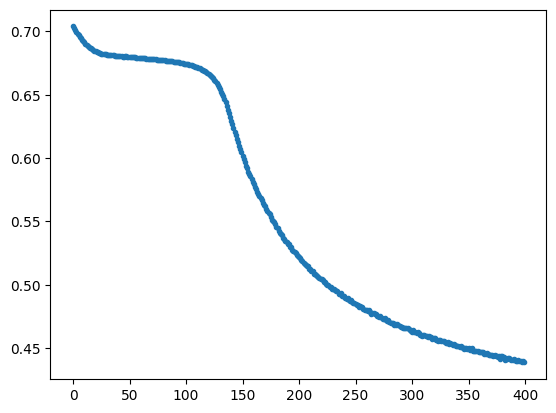

In [129]:
plt.plot(list(map(torch.Tensor.item,train_losses.values())), '.')

0.7176075630322977


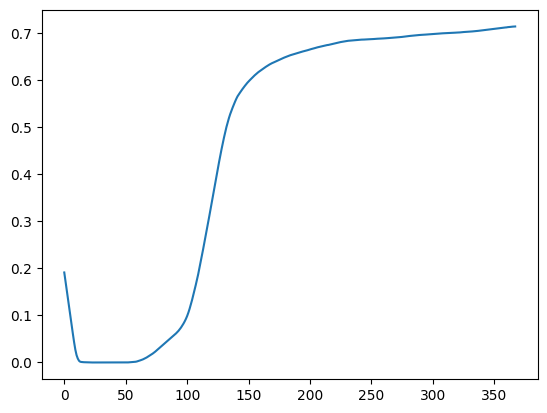

In [133]:
l2 = []
for i in range(len(val_losses.values())-32):
    l2.append(sum(list(val_losses.values())[i:i+32])/32)
plt.plot(l2)
print(max(val_losses.values()))

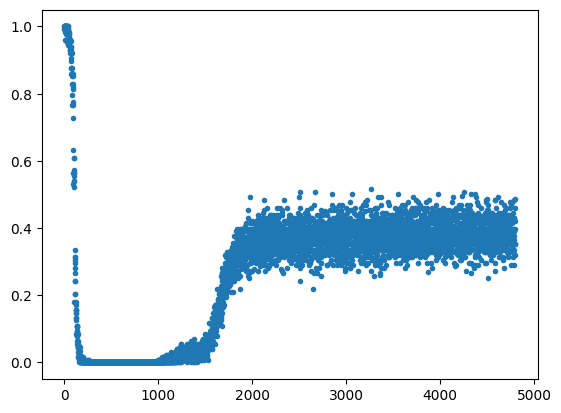

In [131]:
plt.plot([sum(x)/len(x) for x in t1_val], '.') #Plotting what portion of predictions were 1's every validation batch

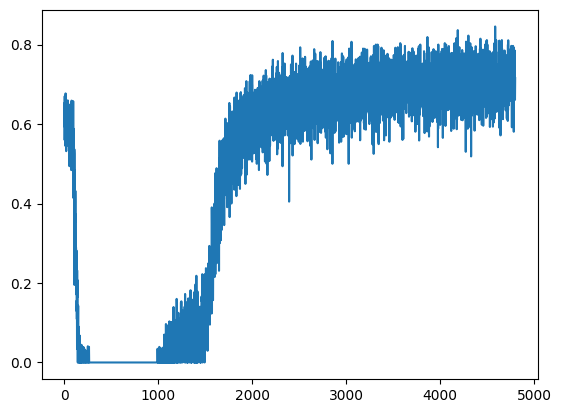

In [132]:
plt.plot(val_batch_losses) #Same as above but no moving mean